In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [6]:
def read_datasets():
    """ Reads user profiles from CSV files """
    genuine_users = pd.read_csv("users.csv")
    fake_users = pd.read_csv("fusers.csv")
    
    x = pd.concat([genuine_users, fake_users])
    y = [1] * len(genuine_users) + [0] * len(fake_users)
    
    return x, y

print("Reading datasets...\n")
x, y = read_datasets()

Reading datasets...



In [7]:
def extract_features(x):
    """ Extract relevant features from dataset """
    lang_list = list(enumerate(np.unique(x['lang'])))
    lang_dict = {name: i for i, name in lang_list}
    
    x['lang_code'] = x['lang'].map(lambda x: lang_dict[x]).astype(int)
    
    feature_columns_to_use = ['statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count', 'lang_code']
    x = x.loc[:, feature_columns_to_use]
    
    return x

print("Extracting features...\n")
x = extract_features(x)

Extracting features...



In [8]:
print("Splitting dataset into training and testing...\n")
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=44)

Splitting dataset into training and testing...



In [15]:
def plot_learning_curve(estimator, title, X, y, cv=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    """Plot the learning curve for a given estimator"""
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, 
                     train_scores_mean - np.std(train_scores, axis=1),
                     train_scores_mean + np.std(train_scores, axis=1), alpha=0.1, color="r")
    plt.fill_between(train_sizes, 
                     test_scores_mean - np.std(test_scores, axis=1),
                     test_scores_mean + np.std(test_scores, axis=1), alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
    plt.legend(loc="best")
    plt.show()

In [20]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Plot the confusion matrix"""
    labels = ['Fake', 'Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    
    fmt = '.2f' if cm.dtype == 'float' else 'd'  # Use 2 decimal places for floats
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


In [17]:
def plot_roc_curve(y_test, y_pred):
    """Plot ROC curve"""
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label=f'AUC = {roc_auc:.2f}')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Training the model...

The best classifier is:
 RandomForestClassifier(n_estimators=40, oob_score=True, random_state=44)
Cross-validation scores: [0.99556541 0.99556541 0.99778271 1.         0.99333333]
Estimated score: 0.99645 (+/- 0.00227)


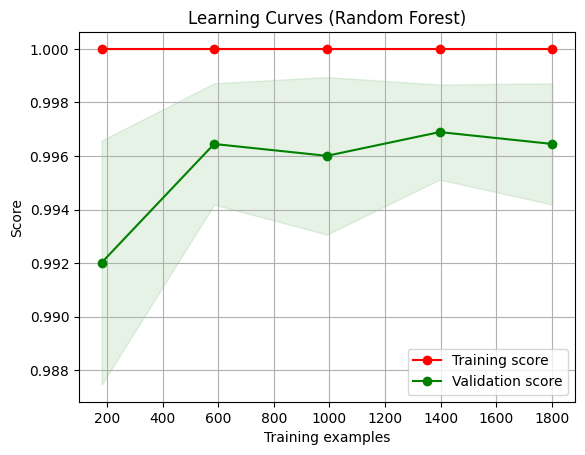

In [18]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    """Train and evaluate the Random Forest model"""
    clf = RandomForestClassifier(n_estimators=40, oob_score=True, random_state=44)
    clf.fit(X_train, y_train)
    
    print("The best classifier is:\n", clf)
    
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f"Cross-validation scores: {scores}")
    print(f"Estimated score: {scores.mean():.5f} (+/- {scores.std():.5f})")
    
    plot_learning_curve(clf, "Learning Curves (Random Forest)", X_train, y_train, cv=5)
    
    y_pred = clf.predict(X_test)
    return y_pred

print("Training the model...\n")
y_pred = train_and_evaluate(X_train, y_train, X_test, y_test)

Classification Accuracy on Test dataset: 0.9964539007092199

Confusion Matrix:
[[266   1]
 [  1 296]]


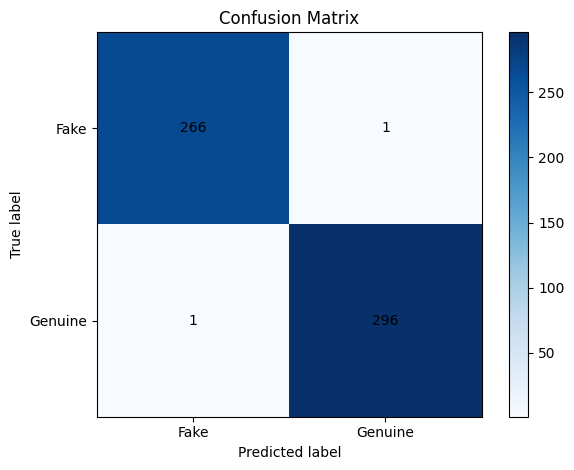


Normalized Confusion Matrix:
[[0.99625468 0.00374532]
 [0.003367   0.996633  ]]


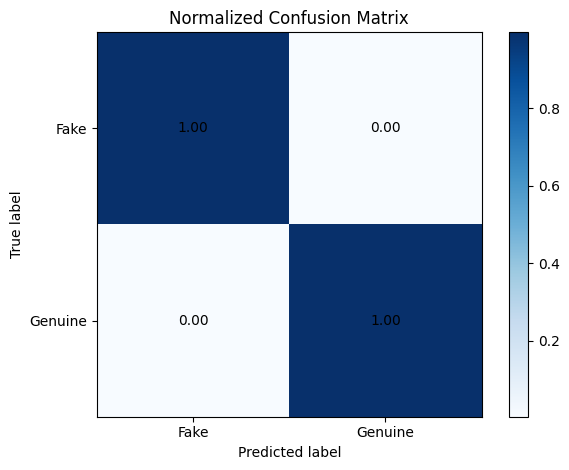


Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       267
     Genuine       1.00      1.00      1.00       297

    accuracy                           1.00       564
   macro avg       1.00      1.00      1.00       564
weighted avg       1.00      1.00      1.00       564


Plotting ROC Curve:


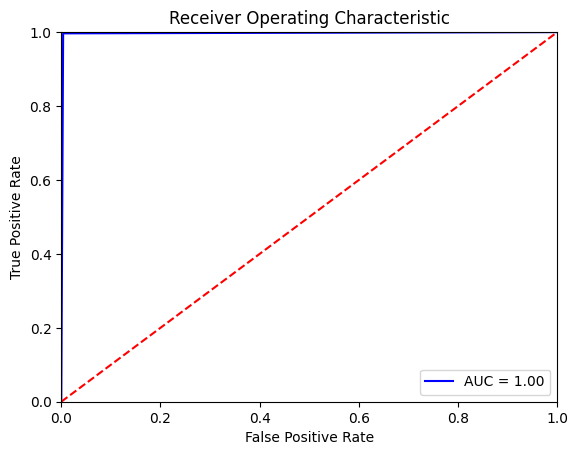

In [21]:
print("Classification Accuracy on Test dataset:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
plot_confusion_matrix(cm)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("\nNormalized Confusion Matrix:")
print(cm_normalized)
plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix')

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Genuine']))

print("\nPlotting ROC Curve:")
plot_roc_curve(y_test, y_pred)


In [22]:
scores = cross_val_score(RandomForestClassifier(n_estimators=40, random_state=44), x, y, cv=5)
print("Cross-validation scores:", scores)
print("Mean CV score:", np.mean(scores))

Cross-validation scores: [0.97695035 0.99822695 1.         1.         0.9982238 ]
Mean CV score: 0.9946802212060517
